In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img.startswith('.'):
                continue
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to load image: {os.path.join(path, img)}")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(data, dtype=object)

In [ ]:
train = get_training_data('/content/drive/MyDrive/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/val')

<Axes: ylabel='count'>

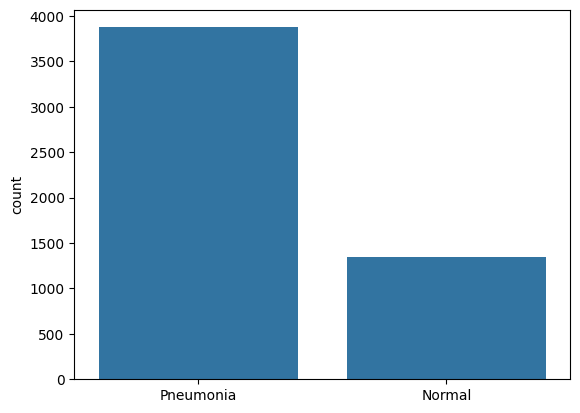

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(x=l)

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
pip install keras-cv --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 27.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_cv
import numpy as np

img_size = 28

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
if x_train.ndim == 3:
    x_train = np.expand_dims(x_train, axis=-1)
    x_val = np.expand_dims(x_val, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
def augment_fn(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

def preprocess(image, label):
    return image, label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .shuffle(1000) \
    .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.reshape(-1)
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.6730322580645162), 1: np.float64(1.9448173005219984)}


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,044,225 (11.61 MB)

 Trainable params: 3,043,265 (11.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    factor=0.3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, learning_rate_reduction, checkpoint],
    class_weight=class_weights_dict
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9556 - auc: 0.4131 - loss: 0.1867
Epoch 1: val_loss improved from inf to 22.21301, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.9554 - auc: 0.4165 - loss: 0.1881 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 22.2130 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9418 - auc: 0.4176 - loss: 0.1071
Epoch 2: val_loss did not improve from 22.21301
163/163 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.9418 - auc: 0.4211 - loss: 0.1077 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 90.3052 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9563 - auc: 0.4304 - loss: 0.0901
Epoch 3: val_loss improved from 22.21301 to 2.91637, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.9563 - auc: 0.4338 - loss: 0.0905 - val_accuracy: 0.6250 - val_auc: 0.7578 - val_

In [ ]:
print("Loss of the model is -", model.evaluate(test_ds)[0])
print("Accuracy of the model is -", model.evaluate(test_ds)[1] * 100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - accuracy: 0.9127 - auc: 0.3924 - loss: 0.3343
Loss of the model is - 0.8845589756965637
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 576ms/step - accuracy: 0.9127 - auc: 0.3924 - loss: 0.3343
Accuracy of the model is - 83.01281929016113 %


Text(0.5, 1.0, 'NORMAL')

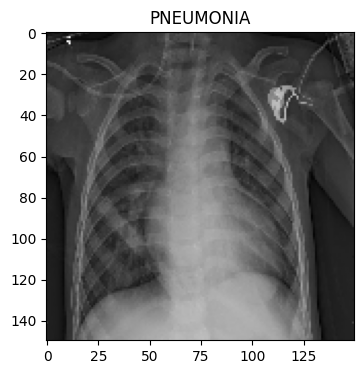

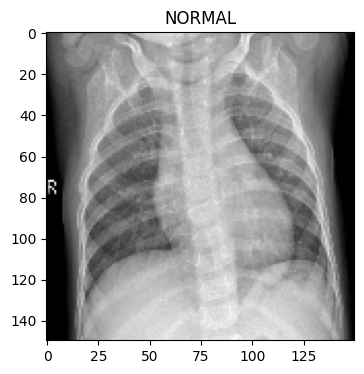

In [ ]:
plt.figure(figsize = (4,4))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (4,4))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

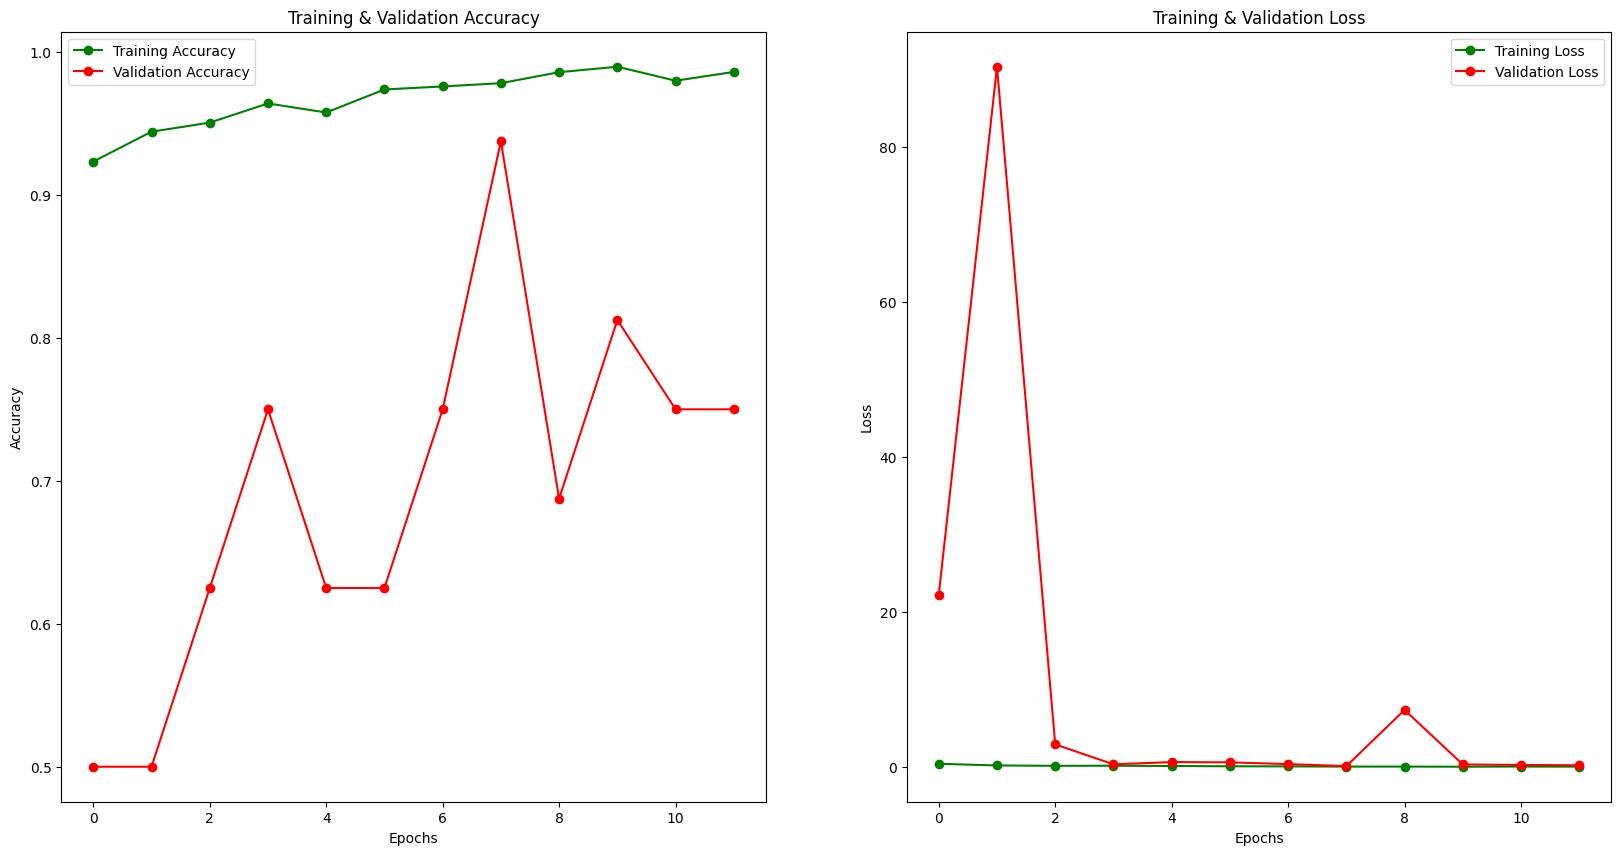

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(history.history['accuracy']))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Accuracy plot
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss plot
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [1]:
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

print(y_pred[:15])
#This applies a decision threshold of 0.5. If probability > 0.5 → model predicts 1 (Pneumonia). If probability ≤ 0.5 → model predicts 0 (Normal).

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.81      0.95      0.88       390
   Normal (Class 1)       0.89      0.62      0.73       234

           accuracy                           0.83       624
          macro avg       0.85      0.79      0.80       624
       weighted avg       0.84      0.83      0.82       624



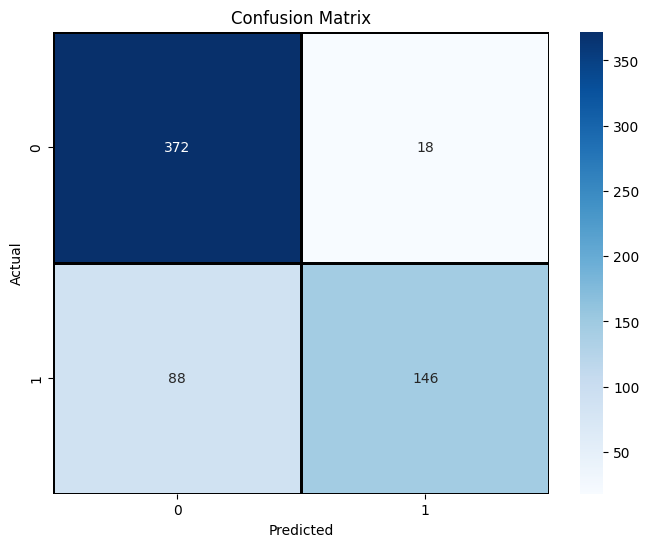

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Medxo/my_pneumonia_pred_model.h5')